#### Project guidelines (comment to be removed)

https://github.com/suneman/socialdataanalysis2020/wiki/Final-Project


# Motivation.
merging Copenhagen traffic data with weather data to check if traffic volumes can be predicted over time and space


### What is your dataset?
* This dataset contains hourly data about some of the busiest roads in Copenhagen that is available from this oppen data page: 
https://www.opendata.dk/city-of-copenhagen/faste-trafiktaellinger#resource-faste_trafikt%C3%A6llinger_2008.xlsx


* The data reported are the total number of vehicles observed on these roads on each hour for all calendar days on each of the relevant roads


* Then for the weather we gathered data from.....


### Why did you choose this/these particular dataset(s)?
We thought it could be interesting to invesigate patterns in the data and try to forecast traffic volumes when we add weather data

### What was your goal for the end user's experience?
Building a tool that allows users to easily visualize the data in space and time and understand how thes traffic volumes/flows distribute across different timeframes, spaces/neighboroughs and weather conditions




# Basic stats. Let's understand the dataset better


### Write about your choices in data cleaning and preprocessing
We have deleted all the empty and oterwise irrelavant columns of data
Then we created new features, mostly time references that we will need to visualize the data by different time references: daily, weekly, yearly, etc.




In [1]:
#import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utm
import folium

Downloading data and removing/adding features

In [2]:
# Downloading faste-trafiktaellinger-2008_clean (to be changed if we get data directly form website)
df = pd.read_csv("C:/Users/User/Dropbox/DTU/02806 Social data analysis and visualization/cph_traffic_2005-2014_original.csv",
                 parse_dates = ['Dato'],encoding='ISO-8859-1')

#renaming "UTM" coordinates
#df = df.rename(columns={'(UTM32)': 'Easting', '(UTM32).1': 'Northing'})

#change the Hours headers
for i in range(7,31):
    df = df.rename(columns={df.columns[i]: df.columns[i].split('.')[1].split('-')[0]})
    df[df.columns[i]] = df[df.columns[i]].str.replace(',', '').fillna(0).astype('float')

# converting UTM coordinates into Latitute/Longitude using the "utm" library: https://pypi.org/project/utm/
# first we create a function that applies the utm api to 2 Series of data
def uf(x):
    return utm.to_latlon(x[0], x[1], 32, 'T')
# then we apply this function to the UTM coordinates in the file
#df['LatLon'] = df[['Easting','Northing']].apply(uf, axis=1)
df[['Lat', 'Lon']] = pd.DataFrame(df[['(UTM32)','(UTM32).1']].apply(uf, axis=1).tolist(), index=df.index)

# randomizing Latitude and longitude points
mi, ma = 0, 0.02
# creating a noise with the same dimension as the dataset (2,2) 
noise1 = np.random.uniform(mi, ma, [len(df),1])
noise2 = np.random.uniform(mi, ma, [len(df),1]) 

df[['Lat_rand']] = df[['Lat']] + noise1
df[['Lon_rand']] = df[['Lon']] + noise2

# removing the unwanted columns
df = df.drop(columns = ['Unnamed: 0','Spor','(UTM32)','(UTM32).1'])

# converting hours data columns into rows
df = df.melt(id_vars=["Vej-Id","Vejnavn","Dato","Lat","Lon","Lat_rand","Lon_rand"],
        value_vars=['00','01','02','03','04','05','06','07','08','09','10','11','12',
                    '13', '14','15', '16','17', '18','19','20','21','22','23'],
        var_name="Hour", 
        value_name="Vehicles")


# Add Day of the Week, Day, ,Week, Month, Year,
df["DayName"] = df['Dato'].apply(lambda x: x.day_name())
df["WeekDay"] = df['Dato'].dt.weekday
df["DayOfMonth"] = df['Dato'].dt.day
df["Week"] = df['Dato'].dt.week
df["Month"] = df['Dato'].dt.month
df["Year"] = df['Dato'].dt.year

# cleaning Vej-Id for more clear traffic direction
df['Vej-Id'] = df['Vej-Id'].str.split(n=4).str[-1]

#df['TotalDailyVehicles'] = df.iloc[:,3:27].sum(axis=1)
#df['TotalDailyVehicles'] = df['Vehicles']

df.head(3)

<ipython-input-2-38fe0fdc2d73>:45: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df["Week"] = df['Dato'].dt.week


Vej-Id       Vejnavn       Dato        Lat        Lon   Lat_rand   Lon_rand  \
0      -  Ellebjergvej 2005-01-04  55.650543  12.510778  55.668118  12.512208   
1      -  Ellebjergvej 2005-02-04  55.650543  12.510778  55.661252  12.521386   
2      -  Ellebjergvej 2005-03-04  55.650543  12.510778  55.657146  12.516243   

  Hour  Vehicles  DayName  WeekDay  DayOfMonth  Week  Month  Year  
0   00      83.0  Tuesday        1           4     1      1  2005  
1   00     153.0   Friday        4           4     5      2  2005  
2   00     182.0   Friday        4           4     9      3  2005

### Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.


Below is the Total Count of vehicles per Road in descending order recorded in the whole period and a barplot that allows the visualization of the data.
From both the list and the plot below you can see how there are significant differences in traffic volumes among the roads chosen in the dataset

# remember to filter only for Vej-Id = "T" in all plots below (other tha the the ones for which you want to check for vehicles entering the City and the ones exiting)!!!!!!!

In [3]:
totcount = df.groupby('Vejnavn')['Vehicles'].sum().sort_values(ascending=False)
pd.DataFrame(totcount.values, index = list(totcount.index), columns =['Total Vehicles']) 

Total Vehicles
Fredensbro                 224539018.0
Ellebjergvej               208574520.0
Kalvebod Brygge            202649325.0
Torvegade                  200340600.0
Tuborgvej                  163046867.0
Ã
boulevard                142917305.0
Vigerslev AllÃ©            123708668.0
Frederikssundsvej          121948873.0
Vejlands AlleÂ´            118548314.0
Hareskovvej                112475351.0
Jagtvej                     92367132.0
Roskildevej                 78916532.0
KalkbrÃ¦nderihavnsgade      78293294.0
Englandsvej                 77235398.0
SÃ¸lvgade                   72539739.0
Ãrestads Boulevard         44436031.0
Gadelandet                  40379765.0
Islands Brygge              28652198.0
Wittenberggade              27023801.0
Mozartsvej                  22625205.0
Molbechsvej                 16905168.0
Skt. Kjelds Gade             6039147.0

<AxesSubplot:>

C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0, flags=flags)


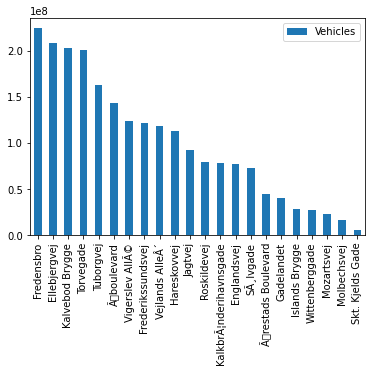

In [4]:
pd.DataFrame(totcount.values, index = list(totcount.index), columns =['Vehicles']).plot.bar()

# Let's look at how the data distribute across time
## Weekly distribution of total vehicles

The main pattern observable is the w-e drop in traffic

<AxesSubplot:xlabel='WeekDay'>

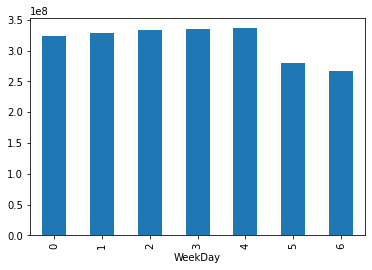

In [5]:
df.groupby('WeekDay')['Vehicles'].sum().plot.bar()

## Weekly distribution per Road
From the plots below a clear drop of traffic on all roads is clearly visible.
2 main exceptions to this pattern are:
* **Kalvebod Brygge** where the drop happens on Mondays and tuesdays. Althought this could be due to some quality issue about the data (we need to check if this is still the case when we include all years (now we are only working with 2008 data)
* **Jagtvej** shows a much lower drop in the w-e compared to other roads


In [6]:
w = df.groupby(["WeekDay", "Vejnavn"]).sum()["Vehicles"].unstack()
w

Vejnavn  Ellebjergvej  Englandsvej  Fredensbro  Frederikssundsvej  Gadelandet  \
WeekDay                                                                         
0          30760398.0   11231740.0  33008616.0         17647208.0   6090732.0   
1          31757962.0   11460476.0  33865476.0         17800581.0   6176770.0   
2          31432412.0   11517308.0  34049103.0         17925949.0   6053012.0   
3          31362652.0   11493514.0  34387357.0         17834460.0   5938621.0   
4          31929022.0   11605406.0  34365091.0         18409056.0   6149762.0   
5          26256770.0   10171412.0  28179883.0         16697288.0   5152138.0   
6          25075304.0    9755542.0  26683492.0         15634331.0   4818730.0   

Vejnavn  Hareskovvej  Islands Brygge     Jagtvej  KalkbrÃ¦nderihavnsgade  \
WeekDay                                                                    
0         16430875.0       4397546.0  13039543.0              11878802.0   
1         17409131.0       4506302.0  13315736.0              12238001.0   
2         17272904.0       4508804.0  13623134.0              12460149.0   
3         17375259.0       4509492.0  13506402.0              12200597.0   
4         17153978.0       4439206.0  13393362.0              12024112.0   
5         13729260.0       3222670.0  12852186.0               8806653.0   
6         13103944.0       3068178.0  12636769.0               8684980.0   

Vejnavn  Kalvebod Brygge  ...  Roskildevej  Skt. Kjelds Gade   SÃ¸lvgade  \
WeekDay                   ...                                              
0             28146873.0  ...   12035301.0          900033.0  10918506.0   
1             27727259.0  ...   11972519.0          918385.0  11038348.0   
2             30870609.0  ...   11551287.0          914689.0  11191288.0   
3             31347762.0  ...   11896039.0          916219.0  11397802.0   
4             31653666.0  ...   12024973.0          889472.0  11235739.0   
5             26986882.0  ...   10182839.0          756146.0   8746142.0   
6             25916274.0  ...    9253574.0          744203.0   8011914.0   

Vejnavn   Torvegade   Tuborgvej  Vejlands AlleÂ´  Vigerslev AllÃ©  \
WeekDay                                                             
0        28966320.0  24735338.0       17738821.0       18081342.0   
1        29418528.0  25326956.0       17692528.0       18479118.0   
2        29816674.0  25430328.0       17905851.0       18696964.0   
3        30031568.0  25179145.0       18004059.0       18783644.0   
4        30189321.0  24691604.0       18179387.0       19003940.0   
5        26182501.0  19057628.0       15122581.0       15817756.0   
6        25735688.0  18625868.0       13905087.0       14845904.0   

Vejnavn  Wittenberggade  Ã
boulevard  Ãrestads Boulevard  
WeekDay                                                    
0             3978748.0   20635783.0            6665746.0  
1             4002954.0   21448485.0            6629324.0  
2             4075376.0   22085050.0            6751878.0  
3             4058582.0   21557950.0            6640162.0  
4             4164516.0   21846514.0            6885556.0  
5             3658237.0   18022466.0            6068408.0  
6             3085388.0   17321057.0            4794957.0  

[7 rows x 22 columns]

array([[<AxesSubplot:title={'center':'Ellebjergvej'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Englandsvej'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Fredensbro'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Frederikssundsvej'}, xlabel='WeekDay'>],
       [<AxesSubplot:title={'center':'Gadelandet'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Hareskovvej'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Islands Brygge'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Jagtvej'}, xlabel='WeekDay'>],
       [<AxesSubplot:title={'center':'KalkbrÃ¦nderihavnsgade'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Kalvebod Brygge'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Molbechsvej'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Mozartsvej'}, xlabel='WeekDay'>],
       [<AxesSubplot:title={'center':'Roskildevej'}, xlabel='WeekDay'>,
        <AxesSubplot:title={'center':'Skt. 

C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0, flags=flags)


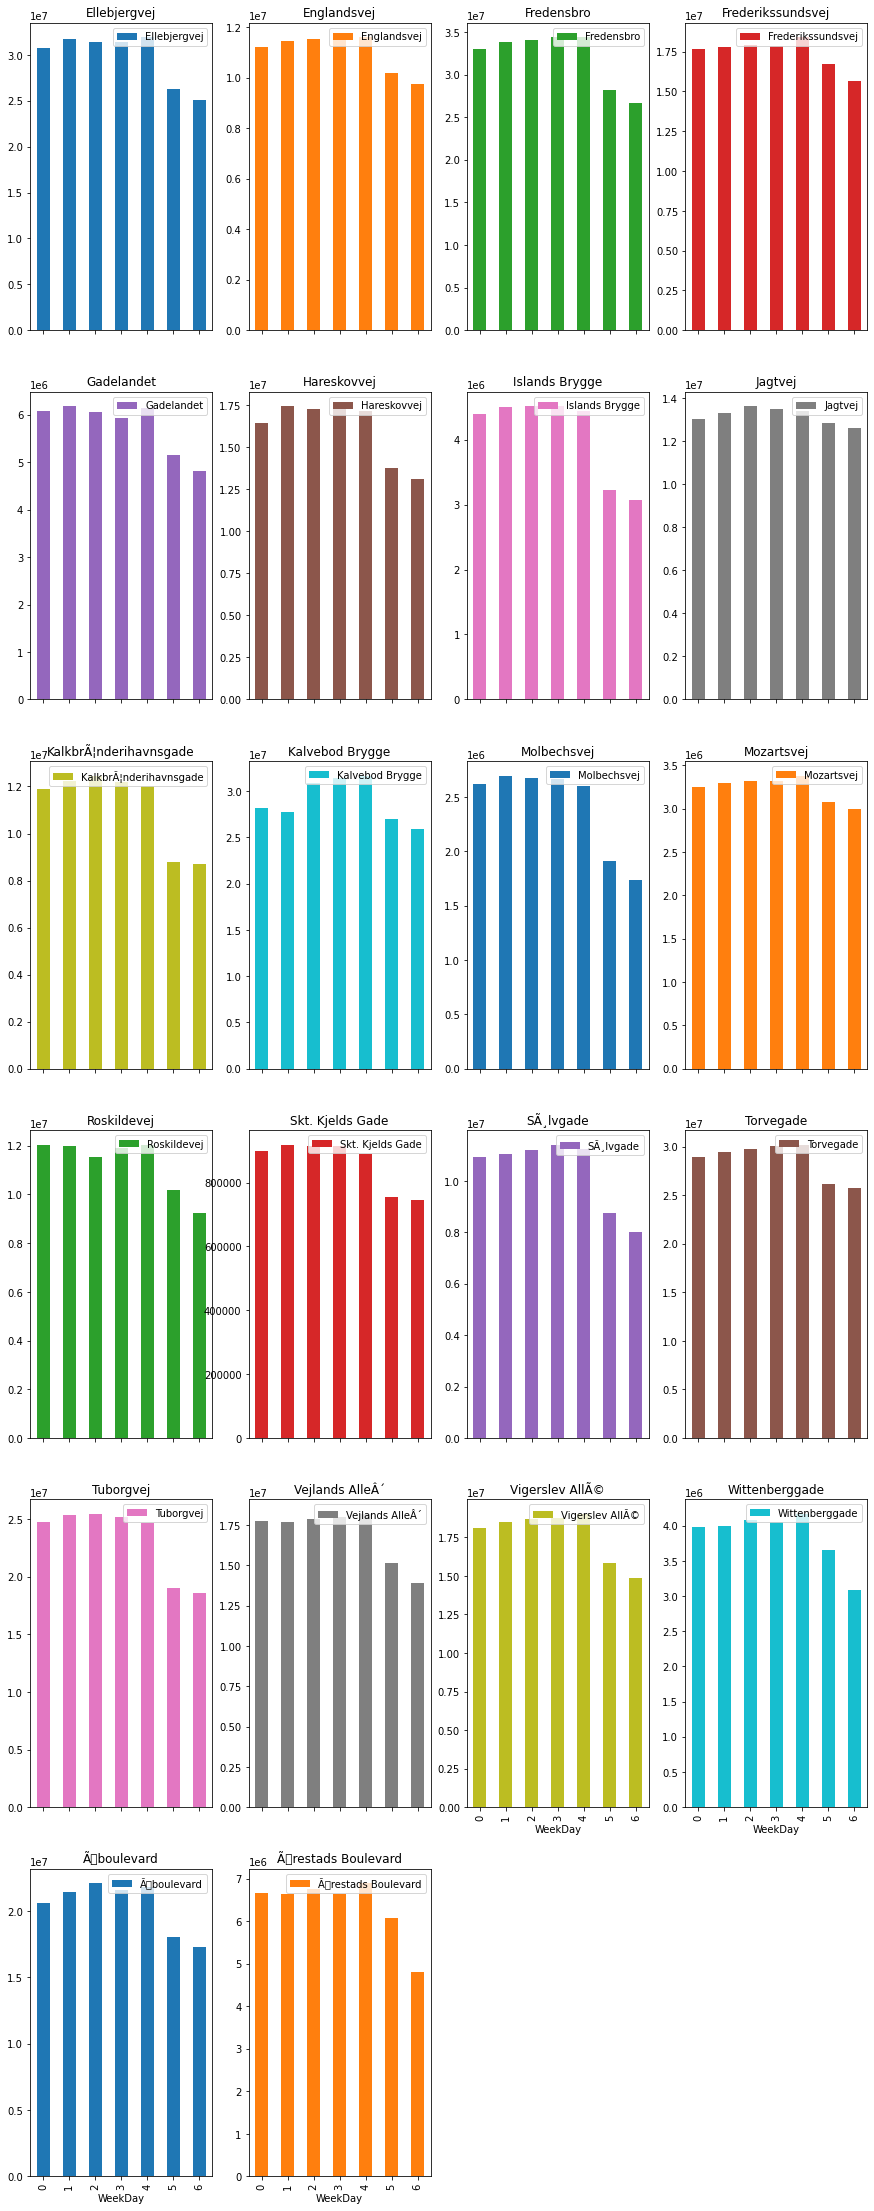

In [7]:
w.plot(kind='bar', subplots=True, figsize=(15,60), layout=(9,4))

## Montly distribution per Road
* The main feature that is clearly visible is the drop in taffic on nearly all roads on July, which is the month where most Copenhageners are on holidays away from the city
* a few roads that except these rule show unclear patterns that could be due to data quality issues (check if this is true after wi enclose other years

In [8]:
m = df.groupby(["Month", "Vejnavn"]).sum()["Vehicles"].unstack()
m

Vejnavn  Ellebjergvej  Englandsvej  Fredensbro  Frederikssundsvej  Gadelandet  \
Month                                                                           
1          16956022.0    6760068.0  19283376.0         10850041.0   3244270.0   
2          15847698.0    6498092.0  17995461.0          9762836.0   3065556.0   
3          17748196.0    7094474.0  19310042.0         11278981.0   3525666.0   
4          17484356.0    7027580.0  18703974.0         10941565.0   3438706.0   
5          18683814.0    7307622.0  19535408.0         10838464.0   3534566.0   
6          18193402.0    6488762.0  18768004.0          9810378.0   3331118.0   
7          17216314.0    6363592.0  17605521.0          9261070.0   3005534.0   
8          18459126.0    5335174.0  19624669.0         10320811.0   3413600.0   
9          18116396.0    6148398.0  19117261.0         10441985.0   3458678.0   
10         18720714.0    6120458.0  18414330.0          9689285.0   3561888.0   
11         16236296.0    6221854.0  18849527.0          9520713.0   3534830.0   
12         14912186.0    5869324.0  17331445.0          9232744.0   3265353.0   

Vejnavn  Hareskovvej  Islands Brygge    Jagtvej  KalkbrÃ¦nderihavnsgade  \
Month                                                                     
1         11515171.0       2401122.0  8327070.0               6949974.0   
2          9607727.0       2199194.0  7471831.0               6432338.0   
3          9846752.0       2278576.0  7580094.0               6799585.0   
4         10453223.0       2350590.0  7386334.0               7128932.0   
5         10506212.0       2519332.0  7683208.0               7168706.0   
6          8944239.0       2581918.0  7504911.0               6666076.0   
7          7052605.0       2277778.0  7790937.0               5944396.0   
8          8914249.0       2511276.0  8158869.0               6388043.0   
9          9584831.0       2443696.0  8453949.0               6339795.0   
10         8945428.0       2481628.0  7553253.0               6306781.0   
11         9221289.0       2513300.0  7683909.0               6711818.0   
12         7883625.0       2093788.0  6772767.0               5456850.0   

Vejnavn  Kalvebod Brygge  ...  Roskildevej  Skt. Kjelds Gade  SÃ¸lvgade  \
Month                     ...                                             
1             18036368.0  ...    6254567.0          514588.0  6234178.0   
2             16529334.0  ...    4612203.0          449896.0  5664196.0   
3             17179444.0  ...    4932867.0          490896.0  6322440.0   
4             16977279.0  ...    4615035.0          493650.0  6048272.0   
5             17109383.0  ...    6497130.0          536676.0  5770190.0   
6             16305010.0  ...    6389924.0          519538.0  6315726.0   
7             15386333.0  ...    7492437.0          440114.0  5397281.0   
8             16801283.0  ...    8013333.0          550103.0  6395534.0   
9             15887334.0  ...    8068668.0          531318.0  6147148.0   
10            18546438.0  ...    8884946.0          534535.0  6352515.0   
11            18397766.0  ...    6695111.0          504316.0  6253878.0   
12            15493353.0  ...    6460311.0          473517.0  5638381.0   

Vejnavn   Torvegade   Tuborgvej  Vejlands AlleÂ´  Vigerslev AllÃ©  \
Month                                                               
1        16967688.0  14630428.0       11683098.0       11200644.0   
2        15326456.0  12330970.0       10747962.0        9029646.0   
3        16892014.0  13900573.0       11968981.0        9733894.0   
4        16436916.0  13252546.0       10409488.0        9407334.0   
5        17381590.0  13882108.0        9125356.0       10118168.0   
6        17088952.0  14866902.0        9015505.0       10316424.0   
7        16414052.0  12817264.0        8474512.0        9324110.0   
8        17182387.0  14380718.0        9333083.0       10943815.0   
9        17107976.0  14584402.0        9260195.0       10996447.0   
10  

array([[<AxesSubplot:title={'center':'Ellebjergvej'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Englandsvej'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Fredensbro'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Frederikssundsvej'}, xlabel='Month'>],
       [<AxesSubplot:title={'center':'Gadelandet'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Hareskovvej'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Islands Brygge'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Jagtvej'}, xlabel='Month'>],
       [<AxesSubplot:title={'center':'KalkbrÃ¦nderihavnsgade'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Kalvebod Brygge'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Molbechsvej'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Mozartsvej'}, xlabel='Month'>],
       [<AxesSubplot:title={'center':'Roskildevej'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Skt. Kjelds Gade'}, xlabel='Mon

C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0, flags=flags)


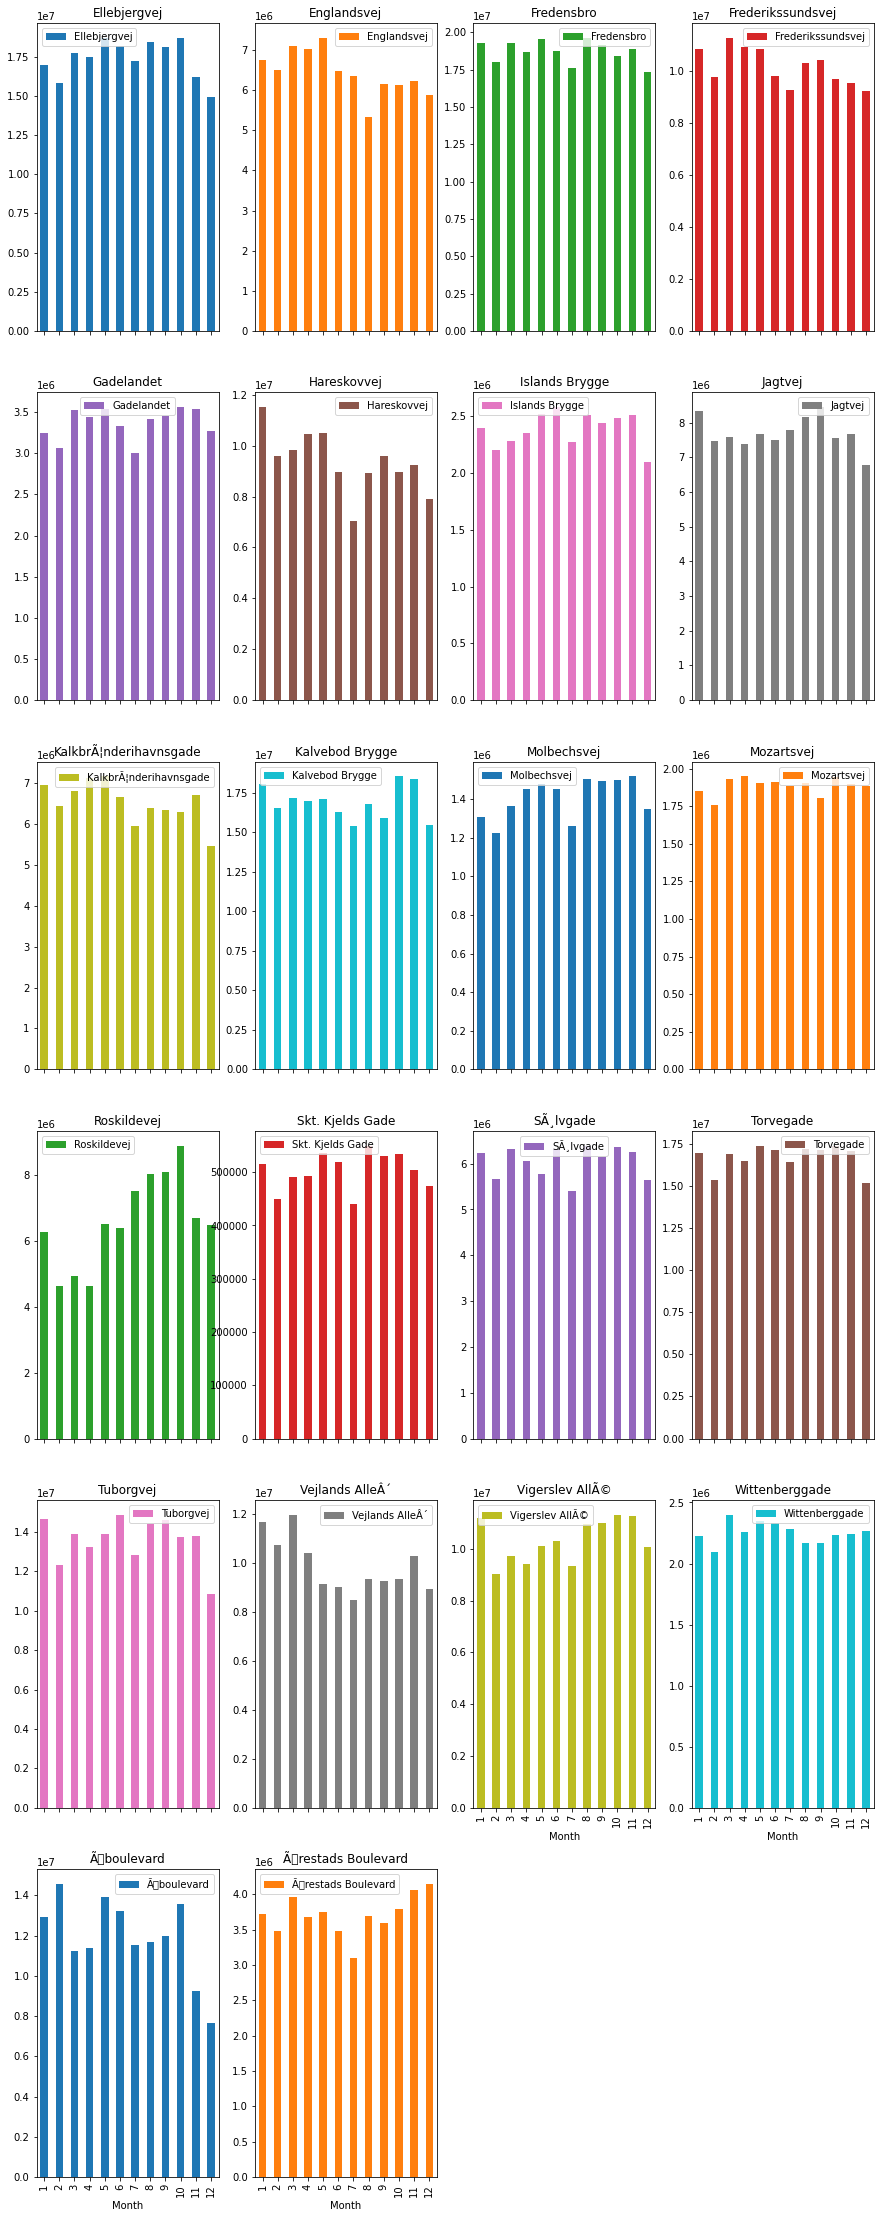

In [9]:
m.plot(kind='bar', subplots=True, figsize=(15,60), layout=(9,4))

## Day of the month distribution per Road
one pattern that can be observed is that the 31st day of the month shows a little more than half the volumes of the average of the other days. This is probably due to the fact that there are ony 7 months that contain 31 days

In [10]:
d = df.groupby(["DayOfMonth", "Vejnavn"]).sum()["Vehicles"].unstack()
d

Vejnavn     Ellebjergvej  Englandsvej  Fredensbro  Frederikssundsvej  \
DayOfMonth                                                             
1              5910894.0    2575126.0   7041054.0          4122366.0   
2              6367226.0    2932330.0   7461570.0          4298650.0   
3              7049040.0    3031060.0   8735160.0          4418571.0   
4              7025742.0    2837574.0   7279287.0          4731202.0   
5              7099970.0    2993262.0   7837284.0          4284836.0   
6              6533388.0    2283476.0   6944311.0          3353108.0   
7              7145020.0    2498932.0   7330545.0          3551926.0   
8              7227978.0    2338654.0   7287944.0          3933095.0   
9              7339806.0    2314650.0   7995407.0          4180634.0   
10             7605550.0    2203092.0   7190985.0          3677130.0   
11             6971580.0    2289414.0   7471791.0          4241574.0   
12             5916518.0    2213444.0   6206074.0          3351472.0   
13             6849184.0    2542822.0   7376601.0          3983816.0   
14             6865212.0    2580666.0   7348106.0          3987985.0   
15             6842430.0    2547278.0   7319764.0          4009024.0   
16             6779950.0    2480406.0   7262136.0          3985686.0   
17             6737508.0    2458364.0   7235245.0          3934738.0   
18             6756474.0    2517268.0   7383646.0          3991206.0   
19             6882084.0    2493918.0   7437412.0          4030812.0   
20             6903062.0    2498530.0   7381101.0          4024245.0   
21             6991926.0    2535382.0   7405825.0          4052782.0   
22             6787548.0    2544048.0   7484825.0          4021767.0   
23             6801422.0    2579448.0   7451469.0          4057853.0   
24             6713338.0    2542162.0   7182589.0          3957142.0   
25             6756796.0    2555196.0   7276602.0          3952670.0   
26             6713550.0    2539236.0   7225595.0          3932352.0   
27             6937506.0    2572520.0   7490426.0          4008126.0   
28             7017208.0    2572558.0   7498561.0          4034420.0   
29             6606508.0    2405150.0   7056946.0          3773084.0   
30             6514866.0    2349248.0   6831545.0          3733133.0   
31             3925236.0    1410184.0   4109212.0          2333468.0   

Vejnavn     Gadelandet  Hareskovvej  Islands Brygge    Jagtvej  \
DayOfMonth                                                       
1            1176976.0    3618466.0        892590.0  2962172.0   
2            1210538.0    4667537.0        975954.0  3693820.0   
3            1443854.0    4157132.0        948704.0  2632072.0   
4            1372992.0    4276316.0        894446.0  2876506.0   
5            1405532.0    5252444.0        881694.0  2661006.0   
6            1213242.0    3987460.0        936652.0  2454700.0   
7            1072480.0    3046713.0        989920.0  3062802.0   
8            1228608.0    2040446.0        989082.0  3316423.0   
9            1390052.0    3836406.0       1007232.0  3542594.0   
10           1372508.0    3626692.0        926452.0  3410782.0   
11           1453948.0    3453423.0       1022324.0  3397576.0   
12           1380799.0    2849826.0        879520.0  2507856.0   
13           1317570.0    3777124.0        937956.0  3041710.0   
14           1315880.0    3986548.0        947582.0  3057363.0   
15           1326204.0    3885186.0        941668.0  3072388.0   
16           1311482.0    3834786.0        932758.0  3017183.0   
17           1317110.0    3858970.0        933386.0  3008256.0   
18           1323918.0    3901915.0        947462.0  3033553.0   
19           1357534.0    4033903.0        958298.0  3018424.0   
20           1368000.0    3821029.0        950902.0  2997363.0   
21           1352866.0    3650207.0        945668.0  3042867.0   
22           1365604.0    3689580.0        933924.0  3048815.0   
23           1341154.0    3540175.0    

array([[<AxesSubplot:title={'center':'Ellebjergvej'}, xlabel='DayOfMonth'>,
        <AxesSubplot:title={'center':'Englandsvej'}, xlabel='DayOfMonth'>,
        <AxesSubplot:title={'center':'Fredensbro'}, xlabel='DayOfMonth'>,
        <AxesSubplot:title={'center':'Frederikssundsvej'}, xlabel='DayOfMonth'>],
       [<AxesSubplot:title={'center':'Gadelandet'}, xlabel='DayOfMonth'>,
        <AxesSubplot:title={'center':'Hareskovvej'}, xlabel='DayOfMonth'>,
        <AxesSubplot:title={'center':'Islands Brygge'}, xlabel='DayOfMonth'>,
        <AxesSubplot:title={'center':'Jagtvej'}, xlabel='DayOfMonth'>],
       [<AxesSubplot:title={'center':'KalkbrÃ¦nderihavnsgade'}, xlabel='DayOfMonth'>,
        <AxesSubplot:title={'center':'Kalvebod Brygge'}, xlabel='DayOfMonth'>,
        <AxesSubplot:title={'center':'Molbechsvej'}, xlabel='DayOfMonth'>,
        <AxesSubplot:title={'center':'Mozartsvej'}, xlabel='DayOfMonth'>],
       [<AxesSubplot:title={'center':'Roskildevej'}, xlabel='DayOfMonth'>,
    

C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0, flags=flags)


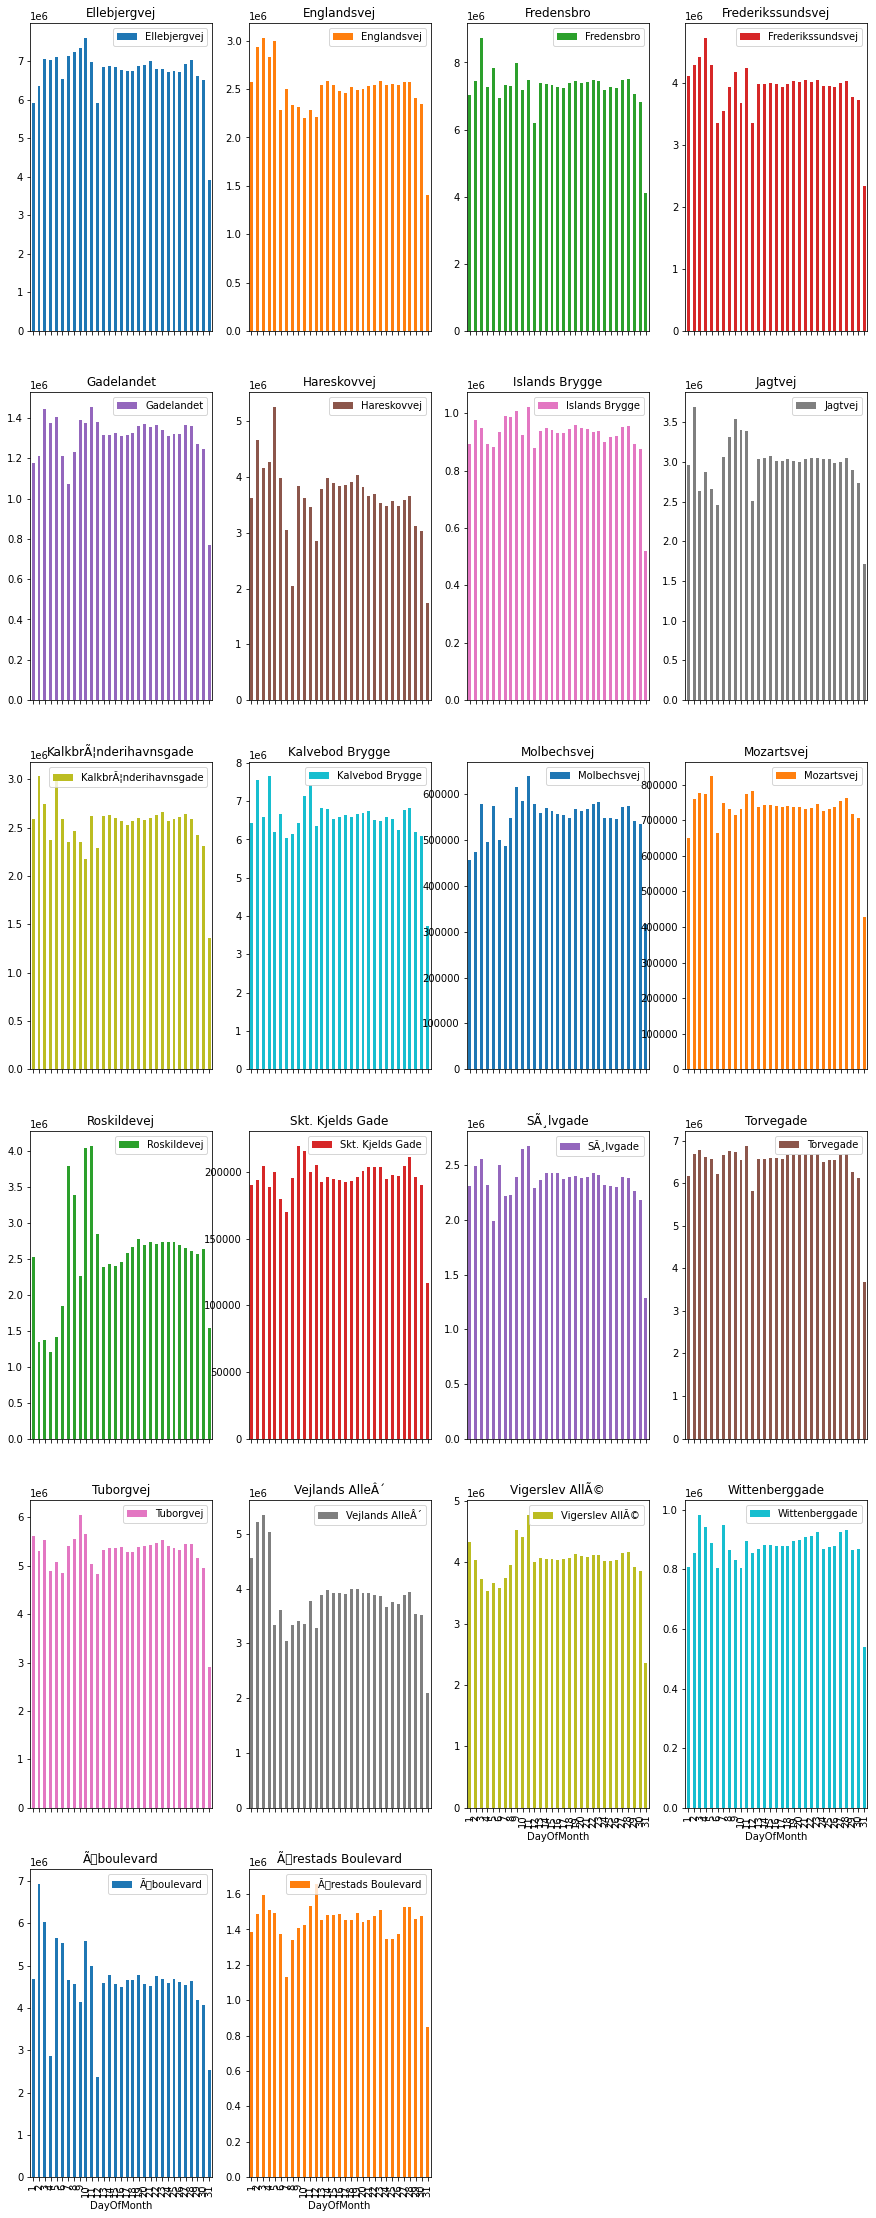

In [11]:
d.plot(kind='bar', subplots=True, figsize=(15,60), layout=(9,4))

## Yearly distribution per Road
* The main feature that is clearly visible is the drop in taffic on nearly all roads on July, which is the month where most Copenhageners are on holidays away from the city
* a few roads that except these rule show unclear patterns that could be due to data quality issues (check if this is true after wi enclose other years

In [12]:
y = df.groupby(["Year", "Vejnavn"]).sum()["Vehicles"].unstack()
y

Vejnavn  Ellebjergvej  Englandsvej  Fredensbro  Frederikssundsvej  Gadelandet  \
Year                                                                            
2005       15857658.0    5240858.0  20651952.0         13232860.0         NaN   
2006       22957960.0   10916466.0  26593164.0         16458272.0   3839166.0   
2007       25279668.0   10646642.0  29143130.0         17475978.0   4947514.0   
2008       24868666.0    9711986.0  29044400.0         15680518.0   4830638.0   
2009       18471934.0    5738366.0  29249279.0         12796583.0   4653702.0   
2010        7976502.0    9311078.0  15346947.0         12421095.0   4371792.0   
2011       24581180.0    9573430.0  14734814.0         11429286.0   4405712.0   
2012       24046784.0   10351216.0  22589246.0          4022660.0   4425201.0   
2013       24185490.0    5745356.0  25876224.0          7444717.0   4353440.0   
2014       20348678.0          NaN  11309862.0         10986904.0   4552600.0   

Vejnavn  Hareskovvej  Islands Brygge     Jagtvej  KalkbrÃ¦nderihavnsgade  \
Year                                                                       
2005      23646336.0       2496632.0   6237496.0               9068864.0   
2006      23107166.0       2844654.0  13417076.0              10916126.0   
2007      13904893.0       3110030.0  13507334.0              12673884.0   
2008      23991308.0       3132162.0  14724056.0              11405735.0   
2009       9543376.0       2901090.0  14636536.0              11626918.0   
2010      14221200.0       2743486.0  14047991.0              11772220.0   
2011       4061072.0       3259874.0  10532368.0               6792082.0   
2012             NaN       2787788.0   2886860.0               4037465.0   
2013             NaN       2701680.0   2377415.0                     NaN   
2014             NaN       2674802.0         NaN                     NaN   

Vejnavn  Kalvebod Brygge  ...  Roskildevej  Skt. Kjelds Gade   SÃ¸lvgade  \
Year                      ...                                              
2005          11376276.0  ...          NaN               NaN   4892220.0   
2006          13153493.0  ...          NaN          664348.0   3784154.0   
2007          23225654.0  ...          NaN          755896.0   9763588.0   
2008          28326756.0  ...          NaN          618602.0   9273570.0   
2009          11732436.0  ...          NaN           76588.0   8861544.0   
2010          18451350.0  ...          NaN          734267.0   8040024.0   
2011          25749981.0  ...   21218158.0          750862.0   9119943.0   
2012          22269226.0  ...   33169633.0          809697.0  10359132.0   
2013          23255516.0  ...   21765549.0          739719.0   8445564.0   
2014          25108637.0  ...    2763192.0          889168.0         NaN   

Vejnavn   Torvegade   Tuborgvej  Vejlands AlleÂ´  Vigerslev AllÃ©  \
Year                                                                
2005     18012584.0  10897582.0       12462948.0        6518930.0   
2006     19671438.0  18328822.0        7988685.0       15334992.0   
2007     21754344.0  21717956.0       14096574.0       16439934.0   
2008     21168919.0  21336624.0       12748562.0       15960134.0   
2009     20402983.0  20169566.0       12500542.0       15989300.0   
2010     19953626.0  18178231.0       12303396.0       14016428.0   
2011     20464236.0  18916798.0       10624878.0        1691952.0   
2012     20697232.0  19389426.0       15187209.0        9142911.0   
2013     19257988.0  14111862.0       12830740.0       14396065.0   
2014     18957250.0         NaN        7804780.0       14218022.0   

Vejnavn  Wittenberggade  Ã
boulevard  Ãrestads Boulevard  
Year                                                       
2005                NaN   26277900.0                  NaN  
2006          3171006.0   20886474.0            3403824.0  
2007          3949258.0   26643242.0            5119581.0  
2008          3724241.0   25158122.0            5199160.0  
2009        

array([[<AxesSubplot:title={'center':'Ellebjergvej'}, xlabel='Year'>,
        <AxesSubplot:title={'center':'Englandsvej'}, xlabel='Year'>,
        <AxesSubplot:title={'center':'Fredensbro'}, xlabel='Year'>,
        <AxesSubplot:title={'center':'Frederikssundsvej'}, xlabel='Year'>],
       [<AxesSubplot:title={'center':'Gadelandet'}, xlabel='Year'>,
        <AxesSubplot:title={'center':'Hareskovvej'}, xlabel='Year'>,
        <AxesSubplot:title={'center':'Islands Brygge'}, xlabel='Year'>,
        <AxesSubplot:title={'center':'Jagtvej'}, xlabel='Year'>],
       [<AxesSubplot:title={'center':'KalkbrÃ¦nderihavnsgade'}, xlabel='Year'>,
        <AxesSubplot:title={'center':'Kalvebod Brygge'}, xlabel='Year'>,
        <AxesSubplot:title={'center':'Molbechsvej'}, xlabel='Year'>,
        <AxesSubplot:title={'center':'Mozartsvej'}, xlabel='Year'>],
       [<AxesSubplot:title={'center':'Roskildevej'}, xlabel='Year'>,
        <AxesSubplot:title={'center':'Skt. Kjelds Gade'}, xlabel='Year'>,
        

C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\User\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 152 missing from current font.
  font.set_text(s, 0, flags=flags)


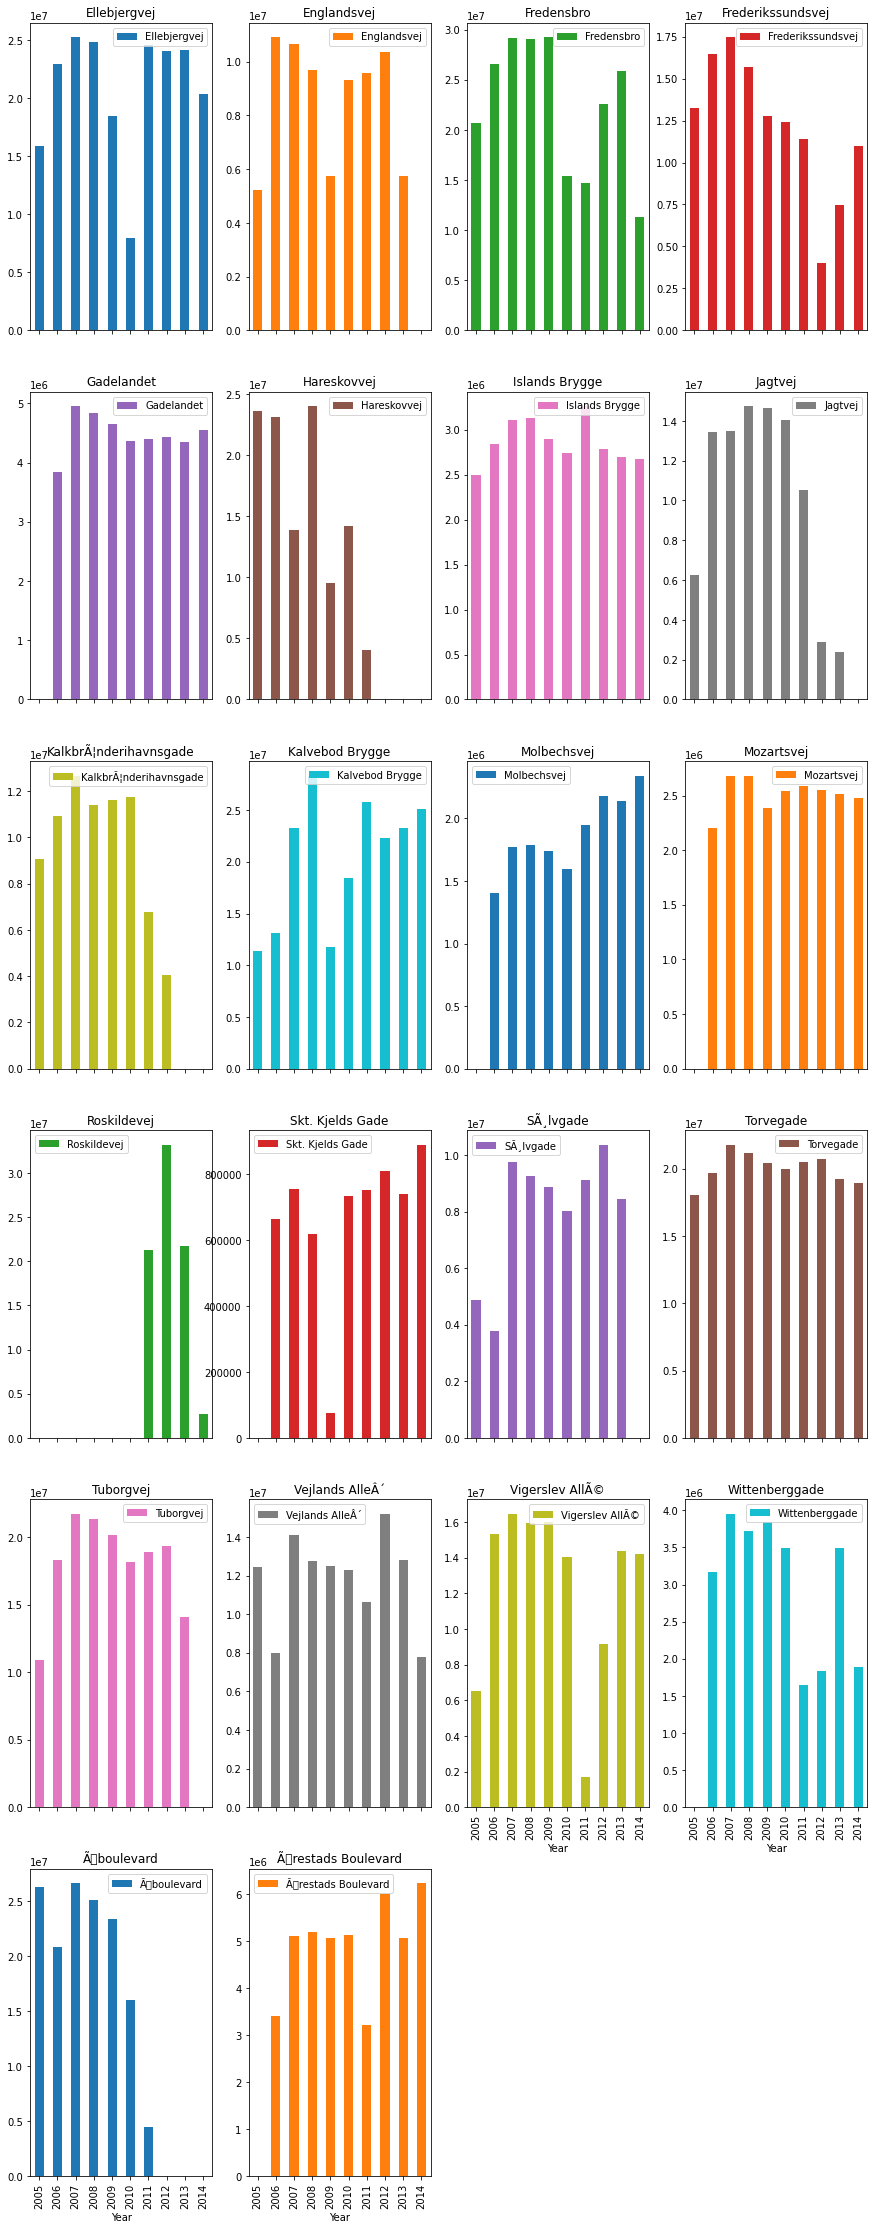

In [13]:
y.plot(kind='bar', subplots=True, figsize=(15,60), layout=(9,4))

# Visualize data in space/time to identify some patterns

# Radhusplads

In [14]:
import folium

map_hooray = folium.Map([55.6761, 12.5683], tiles = "Stamen Toner", zoom_start=12.5)

folium.Marker([55.6761, 12.5683], 
              popup='RadHus Plads', 
              icon=folium.Icon(color='blue')
             ).add_to(map_hooray)

map_hooray

# Visualizing some traffic data

In [38]:
df1 = df[(df['DayOfMonth'].isin([1,2,3,4,5,2,3,4,5,6,7,8,9,10,
                                11,12,13,14,15,16,17,18,19,20,
                                21,22,23,24,25,26,27,28,29,30,31]))
         & (df['Hour'].isin(['07','08']))
         & (df['Month'].isin([6, 7]))
         & (df['Year'] == 2008)
        & (df['Vej-Id'] == 'T')]

df1

Vej-Id       Vejnavn       Dato        Lat        Lon   Lat_rand  \
1335633      T  Ellebjergvej 2008-06-01  55.650543  12.510778  55.659795   
1335634      T  Ellebjergvej 2008-07-01  55.650543  12.510778  55.665089   
1335664      T  Ellebjergvej 2008-06-02  55.650543  12.510778  55.661452   
1335665      T  Ellebjergvej 2008-07-02  55.650543  12.510778  55.668246   
1335717      T  Ellebjergvej 2008-06-04  55.650543  12.510778  55.664630   
...        ...           ...        ...        ...        ...        ...   
1540515      T   Ã
boulevard 2008-06-10  55.683375  12.555882  55.689409   
1540516      T   Ã
boulevard 2008-07-10  55.683375  12.555882  55.700621   
1540546      T   Ã
boulevard 2008-06-11  55.683375  12.555882  55.689961   
1540559      T   Ã
boulevard 2008-06-12  55.683375  12.555882  55.698451   
1540560      T   Ã
boulevard 2008-07-12  55.683375  12.555882  55.690365   

          Lon_rand Hour  Vehicles    DayName  WeekDay  DayOfMonth  Week  \
1335633  12.520376   07     333.0     Sunday        6           1    22   
1335634  12.527396   07    2830.0    Tuesday        1           1    27   
1335664  12.518102   07    2860.0     Monday        0           2    23   
1335665  12.519938   07    2822.0  Wednesday        2           2    27   
1335717  12.527461   07     399.0  Wednesday        2           4    23   
...            ...  ...       ...        ...      ...         ...   ...   
1540515  12.560267   08    3692.0    Tuesday        1          10    24   
1540516  12.564781   08    4047.0   Thursday        3          10    28   
1540546  12.573045   08    3686.0  Wednesday        2          11    24   
1540559  12.556070   08     736.0   Thursday        3          12    24   
1540560  12.574827   08     466.0   Saturday        5          12    28   

         Month  Year  
1335633      6  2008  
1335634      7  2008  
1335664      6  2008  
1335665      7  2008  
1335717      6  2008  
...        ...   ...  
1540515      6  2008  
1540516      7  2008  
1540546      6  2008  
1540559      6  2008  
1540560      7  2008  

[2526 rows x 15 columns]

In [39]:
map2 = folium.Map([55.6761, 12.5683], tiles = "Stamen Toner", zoom_start=12)

folium.Marker([55.6761, 12.5683], 
              popup='City Hall', 
              icon=folium.Icon(color='blue')
             ).add_to(map2)

for i in range(len(df1)):
    folium.Circle(location=[df1.iloc[i]['Lat'], df1.iloc[i]['Lon']],
                  popup=df1.iloc[i]['Month'],
                  radius=4, #data.iloc[i]['value']*10000,
                  color='crimson',
                  fill=True,
                  fill_color='crimson'
                 ).add_to(map2)

map2

# Heatmap

In [40]:
from folium.plugins import HeatMap

map_hooray = folium.Map([55.6761, 12.5683], tiles = "Stamen Toner", zoom_start=12)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = df1[['Lat', 'Lon']]
#heat_df = heat_df.dropna(axis=0, subset=['Y','X'])



# List comprehension to make out list of lists
heat_data = [[row['Lat'],row['Lon']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(map_hooray)

# Display the map
map_hooray

# HeatMapWithTime  (Weekdays) 

In [41]:
from folium import plugins

map_hooray = folium.Map([55.6761, 12.5683], tiles = "Stamen Toner", zoom_start=12)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = df1[['Lat', 'Lon','Lat_rand', 'Lon_rand']]
#heat_df = heat_df.dropna(axis=0, subset=['Y','X'])

# List comprehension to make out list of lists
heat_data = [[row['Lat'],row['Lon']] for index, row in heat_df.iterrows()]

# Create weight column, using date
heat_df['Weight'] = df1['WeekDay']
heat_df['Weight'] = heat_df['Weight'].astype(float)
heat_df = heat_df.dropna(axis=0, subset=['Lat','Lon', 'Weight'])

# List comprehension to make out list of lists
heat_data = [[[row['Lat'],row['Lon']] for index, row in heat_df[heat_df['Weight'] == i].iterrows()] for i in range(0,7)]

# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(map_hooray)
# Display the map
map_hooray

<ipython-input-41-8178631b64e2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heat_df['Weight'] = df1['WeekDay']
<ipython-input-41-8178631b64e2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heat_df['Weight'] = heat_df['Weight'].astype(float)


# HeatMapWithTime  (Weekdays) WITH RANDOMISED DATA

In [42]:
#import numpy as np 
#mu, sigma = 0, 0.02
# creating a noise with the same dimension as the dataset (2,2) 
#noise1 = np.random.uniform(mu, sigma, [len(heat_df),1])
#noise2 = np.random.uniform(mu, sigma, [len(heat_df),1]) 

#heat_lat = heat_df[['Lat']] + noise1
#heat_lon = heat_df[['Lon']] + noise2

#heat_rn = pd.concat([heat_lat, heat_lon, heat_df['Weight']], axis=1)
#heat_rn
heat_df

Lat        Lon   Lat_rand   Lon_rand  Weight
1335633  55.650543  12.510778  55.659795  12.520376     6.0
1335634  55.650543  12.510778  55.665089  12.527396     1.0
1335664  55.650543  12.510778  55.661452  12.518102     0.0
1335665  55.650543  12.510778  55.668246  12.519938     2.0
1335717  55.650543  12.510778  55.664630  12.527461     2.0
...            ...        ...        ...        ...     ...
1540515  55.683375  12.555882  55.689409  12.560267     1.0
1540516  55.683375  12.555882  55.700621  12.564781     3.0
1540546  55.683375  12.555882  55.689961  12.573045     2.0
1540559  55.683375  12.555882  55.698451  12.556070     3.0
1540560  55.683375  12.555882  55.690365  12.574827     5.0

[2526 rows x 5 columns]

In [43]:
from folium import plugins

map_hooray = folium.Map([55.6761, 12.5683], tiles = "Stamen Toner", zoom_start=12)

# randomize traffic data
#mi, ma = 0, 0.02
# creating a noise with the same dimension as the dataset (2,2) 
#noise1 = np.random.uniform(mi, ma, [len(heat_df),1])
#noise2 = np.random.uniform(mi, ma, [len(heat_df),1]) 

#heat_lat = heat_df[['Lat']] + noise1
#heat_lon = heat_df[['Lon']] + noise2

#heat_rn = pd.concat([heat_lat, heat_lon, heat_df['Weight']], axis=1)
heat_rn = pd.concat([heat_df['Lat_rand'], heat_df['Lon_rand'], heat_df['Weight']], axis=1)

# List comprehension to make out list of lists
heat_data_rn = [[[row['Lat_rand'],row['Lon_rand']] for index, row in heat_rn[heat_rn['Weight'] == i].iterrows()] for i in range(0,7)]

# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data_rn,auto_play=True,max_opacity=0.8)
hm.add_to(map_hooray)
# Display the map
map_hooray

# HeatMapWithTime  (DaysOfMonth) 

In [44]:
from folium import plugins

map_hooray = folium.Map([55.6761, 12.5683], tiles = "Stamen Toner", zoom_start=12)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = df1[['Lat', 'Lon']]
#heat_df = heat_df.dropna(axis=0, subset=['Y','X'])

# List comprehension to make out list of lists
heat_data = [[row['Lat'],row['Lon']] for index, row in heat_df.iterrows()]

# Create weight column, using date
heat_df['Weight'] = df1['WeekDay']
heat_df['Weight'] = heat_df['Weight'].astype(float)
heat_df = heat_df.dropna(axis=0, subset=['Lat','Lon', 'Weight'])

# List comprehension to make out list of lists
heat_data = [[[row['Lat'],row['Lon']] for index, row in heat_df[heat_df['Weight'] == i].iterrows()] for i in range(0,7)]

# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(map_hooray)
# Display the map
map_hooray

<ipython-input-44-e48586b3fb11>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heat_df['Weight'] = df1['WeekDay']
<ipython-input-44-e48586b3fb11>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heat_df['Weight'] = heat_df['Weight'].astype(float)


# another option to visualize something in the data is by using normalised data by road